# MisGAN: Learning from Incomplete Data with GANs
Based on [this code](https://github.com/steveli/misgan/blob/master/misgan.ipynb).

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import *
from torchvision import datasets, transforms
import numpy as np
from matplotlib.patches import Rectangle
import pylab as plt
from PIL import Image

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## Loading datasets

In [51]:
ds_label, img_size, mask_size= 'Mnist', 28, 12
# ds_label, img_size, mask_size = 'Fashion', 28, 12
# ds_label, img_size, mask_size = 'CIFAR', 32, 14
raw_data_list = list()
for i in range(10_000):
    img: Image = Image.open('{}/img/{}.jpg'.format(ds_label, i))
    raw_data_list.append(functional.to_tensor(img))

raw_mask_list = list()
labels_file = open('labels{}.csv'.format(ds_label), 'r')
for line in labels_file:
    line_list: list = line.split(',')
    raw_mask_list.append((int(line_list[2]), int(line_list[3])))
    

class BlockMaskedData(Dataset):
    def __init__(self, block_len, img_size, data_list, mask_list):
        self.block_len = block_len
        self.img_size = img_size
        self.data_size = len(data_list)
        self.generate_incomplete_data(data_list, mask_list)

    def __getitem__(self, index):
        # return index so we can retrieve the mask location from self.mask_loc
        return self.image[index], self.mask[index], index

    def __len__(self):
        return self.data_size

    def generate_incomplete_data(self, data, masks):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            d0 = masks[i][1]
            d1 = masks[i][0]
            mask = torch.ones((self.img_size, self.img_size), dtype=torch.uint8)
            mask[d0:(d0 + self.block_len), d1:(d1 + self.block_len)] = 0
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            self.mask_loc[i] = d0, d1, self.block_len, self.block_len
            # Mask out missing pixels by zero
            self.image[i] = (data[i][0] * mask.float()).reshape(1, self.img_size, self.img_size)

In [52]:
data = BlockMaskedData(mask_size, img_size, raw_data_list[:8000], raw_mask_list[:8000])
test_data = BlockMaskedData(mask_size, img_size, raw_data_list[8000:], raw_mask_list[8000:])
batch_size = 64
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                         drop_last=True)

In [53]:
def plot_grid(ax, image, bbox=None, gap=1, gap_value=1, nrow=4, ncol=8,
              title=None):
    image = image.cpu().numpy().squeeze(1)
    LEN = img_size
    grid = np.empty((nrow * (LEN + gap) - gap, ncol * (LEN + gap) - gap))
    grid.fill(gap_value)

    for i, x in enumerate(image):
        if i >= nrow * ncol:
            break
        p0 = (i // ncol) * (LEN + gap)
        p1 = (i % ncol) * (LEN + gap)
        grid[p0:(p0 + LEN), p1:(p1 + LEN)] = x

    ax.set_axis_off()
    ax.imshow(grid, cmap='binary_r', interpolation='none', aspect='equal')

    if bbox:
        nplot = min(len(image), nrow * ncol)
        for i in range(nplot):
            d0, d1, d0_len, d1_len = bbox[i]
            p0 = (i // ncol) * (LEN + gap)
            p1 = (i % ncol) * (LEN + gap)
            offset = np.array([p1 + d1, p0 + d0]) - .5
            ax.add_patch(Rectangle(
                offset, d1_len, d0_len, lw=1.5, edgecolor='red', fill=False))
            
    if title:
        ax.set_title(title)

In [54]:
def mask_data(data, mask, tau=0):
    return mask * data + (1 - mask) * tau

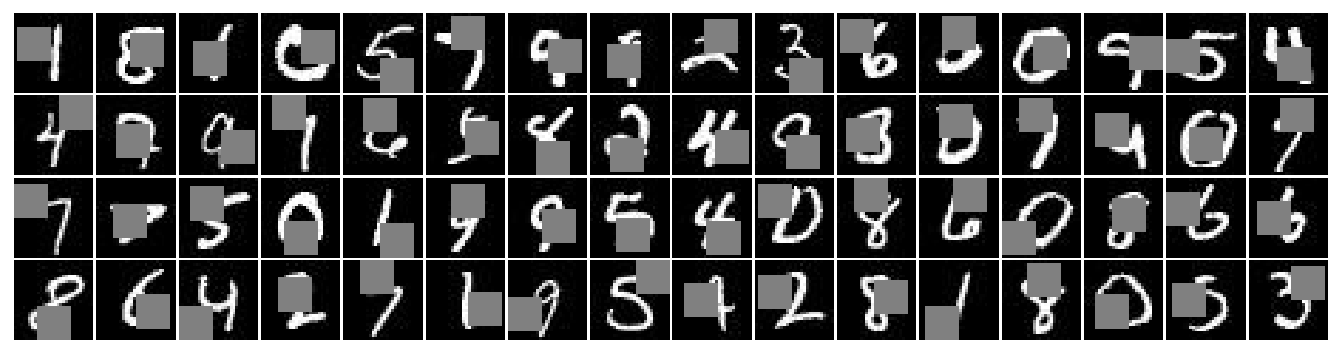

In [55]:
data_samples, mask_samples, _ = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(12, 3))
plot_grid(ax, mask_data(data_samples, mask_samples.float(), .5),
          nrow=4, ncol=16)

## MisGAN

In [56]:
# Must sub-class ConvGenerator to provide transform()
class ConvGenerator(nn.Module):
    def __init__(self, latent_size=128):
        super().__init__()

        self.DIM = 64
        self.latent_size = latent_size

        self.preprocess = nn.Sequential(
            nn.Linear(latent_size, 4 * 4 * 4 * self.DIM),
            nn.ReLU(True),
        )
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * self.DIM, 2 * self.DIM, 5),
            nn.ReLU(True),
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * self.DIM, self.DIM, 5),
            nn.ReLU(True),
        )
        if img_size == 32:
            self.deconv_out = nn.ConvTranspose2d(self.DIM, 1, 12, stride=2)
        else:
            self.deconv_out = nn.ConvTranspose2d(self.DIM, 1, 8, stride=2)

    def forward(self, input):
        net = self.preprocess(input)
        net = net.view(-1, 4 * self.DIM, 4, 4)
        net = self.block1(net)
        net = net[:, :, :7, :7]
        net = self.block2(net)
        net = self.deconv_out(net)
        return self.transform(net).view(-1, 1, img_size, img_size)


class ConvDataGenerator(ConvGenerator):
    def __init__(self, latent_size=128):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x)


class ConvMaskGenerator(ConvGenerator):
    def __init__(self, latent_size=128, temperature=.66):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x / temperature)

In [57]:
class ConvCritic(nn.Module):
    def __init__(self):
        super().__init__()

        self.DIM = 64
        main = nn.Sequential(
            nn.Conv2d(1, self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(self.DIM, 2 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(2 * self.DIM, 4 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
        )
        self.main = main
        self.output = nn.Linear(4 * 4 * 4 * self.DIM, 1)

    def forward(self, input):
        input = input.view(-1, 1, img_size, img_size)
        net = self.main(input)
        net = net.view(-1, 4 * 4 * 4 * self.DIM)
        net = self.output(net)
        return net.view(-1)

In [58]:
class CriticUpdater:
    def __init__(self, critic, critic_optimizer, batch_size=64, gp_lambda=10):
        self.critic = critic
        self.critic_optimizer = critic_optimizer
        self.gp_lambda = gp_lambda
        # Interpolation coefficient
        self.eps = torch.empty(batch_size, 1, 1, 1, device=device)
        # For computing the gradient penalty
        self.ones = torch.ones(batch_size).to(device)

    def __call__(self, real, fake):
        real = real.detach()
        fake = fake.detach()
        self.critic.zero_grad()
        self.eps.uniform_(0, 1)
        interp = (self.eps * real + (1 - self.eps) * fake).requires_grad_()
        grad_d = grad(self.critic(interp), interp, grad_outputs=self.ones,
                      create_graph=True)[0]
        grad_d = grad_d.view(real.shape[0], -1)
        grad_penalty = ((grad_d.norm(dim=1) - 1)**2).mean() * self.gp_lambda
        w_dist = self.critic(fake).mean() - self.critic(real).mean()
        loss = w_dist + grad_penalty
        loss.backward()
        self.critic_optimizer.step()

In [59]:
nz = 128   # dimensionality of the latent code
n_critic = 5
alpha = .2

data_gen = ConvDataGenerator().to(device)
mask_gen = ConvMaskGenerator().to(device)

data_critic = ConvCritic().to(device)
mask_critic = ConvCritic().to(device)

data_noise = torch.empty(batch_size, nz, device=device)
mask_noise = torch.empty(batch_size, nz, device=device)

lrate = 1e-4
data_gen_optimizer = optim.Adam(
    data_gen.parameters(), lr=lrate, betas=(.5, .9))
mask_gen_optimizer = optim.Adam(
    mask_gen.parameters(), lr=lrate, betas=(.5, .9))

data_critic_optimizer = optim.Adam(
    data_critic.parameters(), lr=lrate, betas=(.5, .9))
mask_critic_optimizer = optim.Adam(
    mask_critic.parameters(), lr=lrate, betas=(.5, .9))

update_data_critic = CriticUpdater(
    data_critic, data_critic_optimizer, batch_size)
update_mask_critic = CriticUpdater(
    mask_critic, mask_critic_optimizer, batch_size)

## Missing data imputation
<img src="img/misgan-impute.png" width="625" style="display: block; margin: 2em auto" />

In [60]:
class Imputer(nn.Module):
    def __init__(self, arch=(512, 512)):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(img_size ** 2, arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], arch[1]),
            nn.ReLU(),
            nn.Linear(arch[1], arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], img_size ** 2),
        )

    def forward(self, data, mask, noise):
        net = data * mask + noise * (1 - mask)
        net = net.view(data.shape[0], -1)
        net = self.fc(net)
        net = torch.sigmoid(net).view(data.shape)
        return data * mask + net * (1 - mask)

In [61]:
imputer = Imputer().to(device)
impu_critic = ConvCritic().to(device)
impu_noise = torch.empty(batch_size, 1, img_size, img_size, device=device)

imputer_lrate = 2e-4
imputer_optimizer = optim.Adam(
    imputer.parameters(), lr=imputer_lrate, betas=(.5, .9))
impu_critic_optimizer = optim.Adam(
    impu_critic.parameters(), lr=imputer_lrate, betas=(.5, .9))
update_impu_critic = CriticUpdater(
    impu_critic, impu_critic_optimizer, batch_size)

### Training MisGAN imputer

Epoch: 9


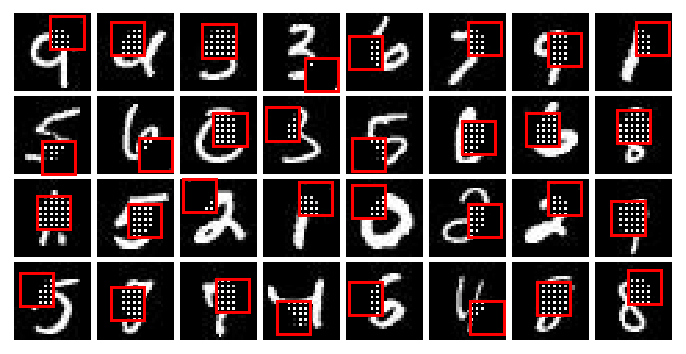

Epoch: 19


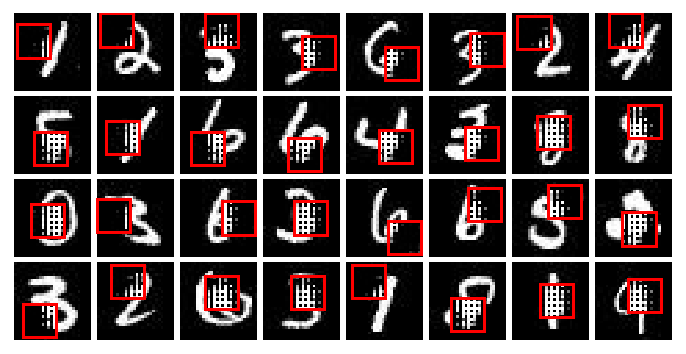

Epoch: 29


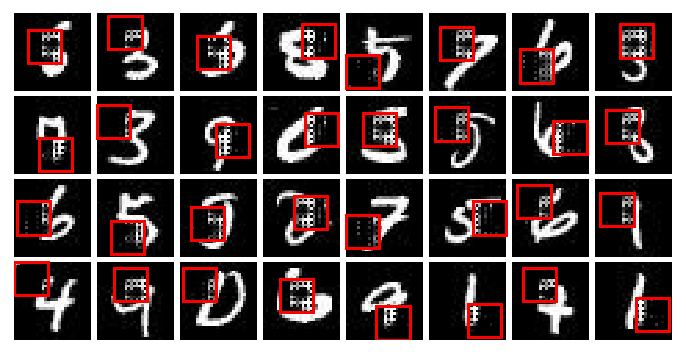

Epoch: 39


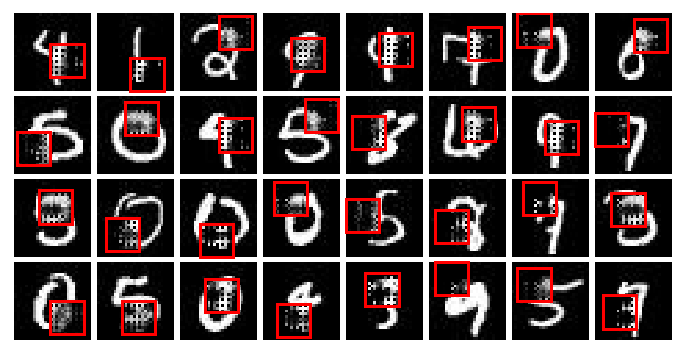

Epoch: 49


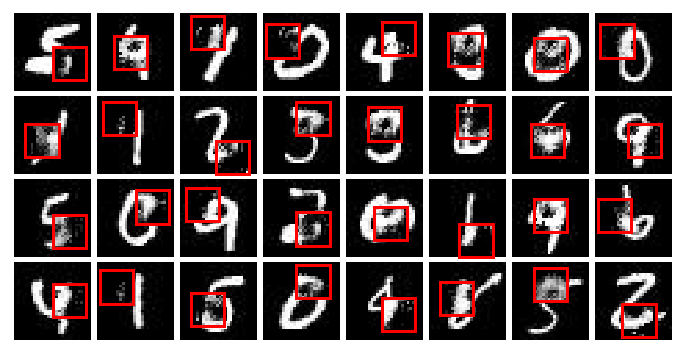

Epoch: 59


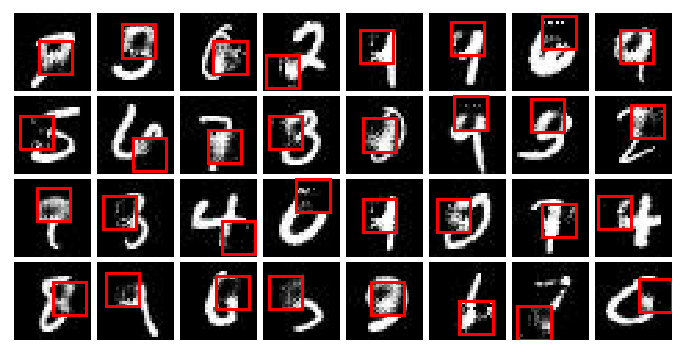

Epoch: 69


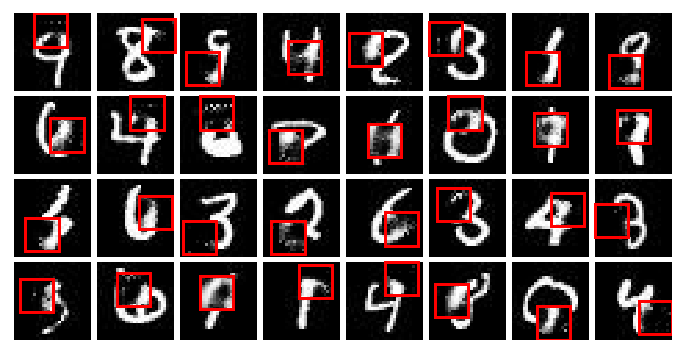

Epoch: 79


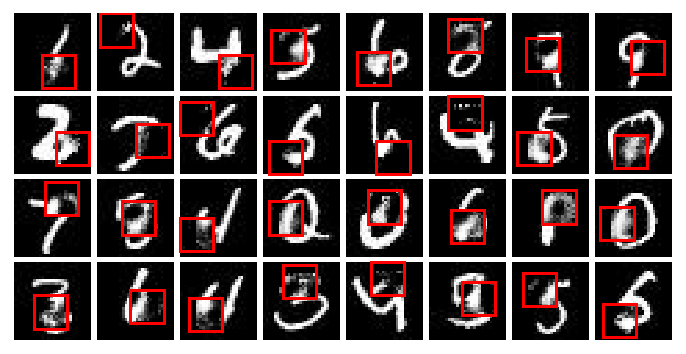

Epoch: 89


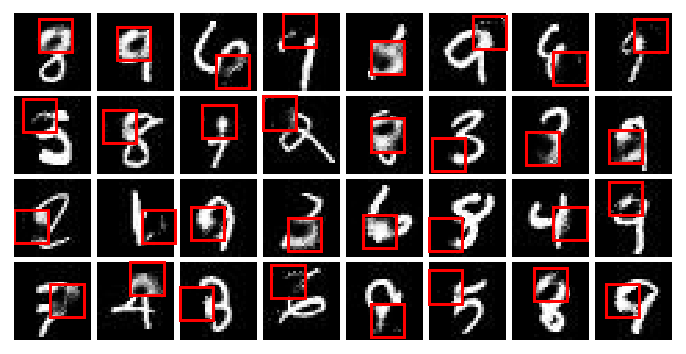

Epoch: 99


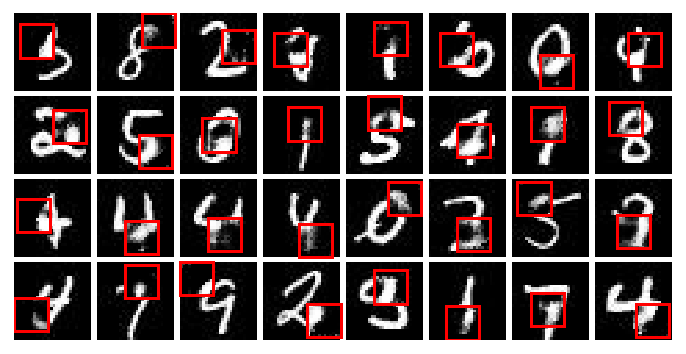

Epoch: 109


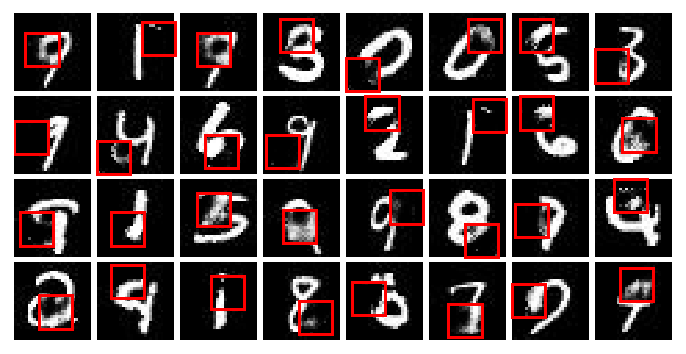

Epoch: 119


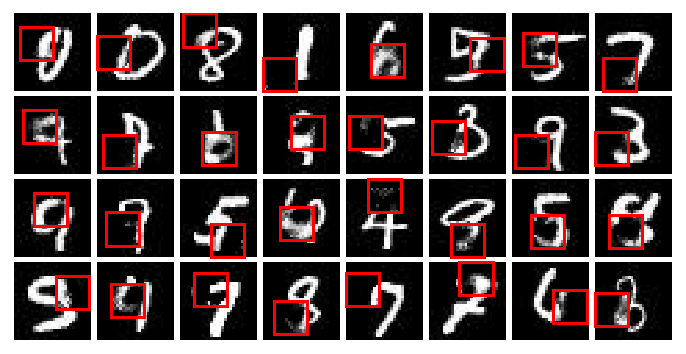

Epoch: 129


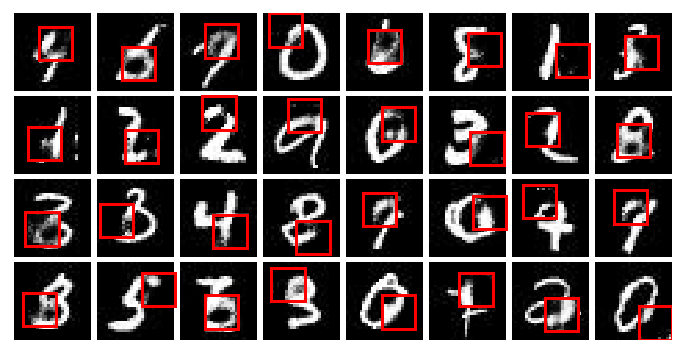

Epoch: 139


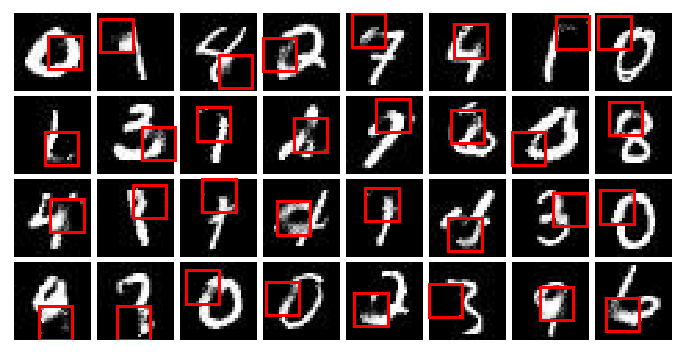

Epoch: 149


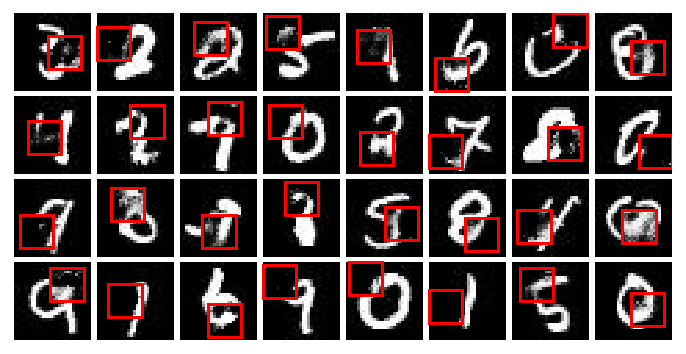

Epoch: 159


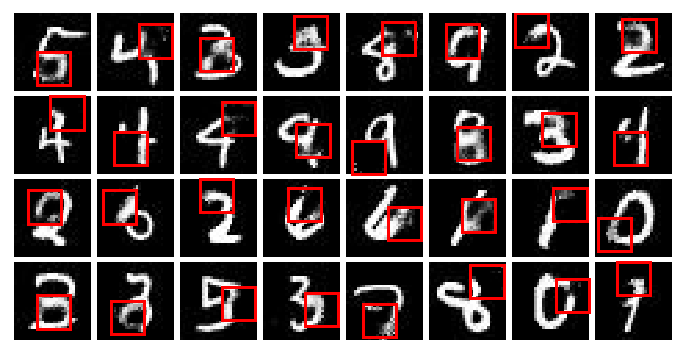

Epoch: 169


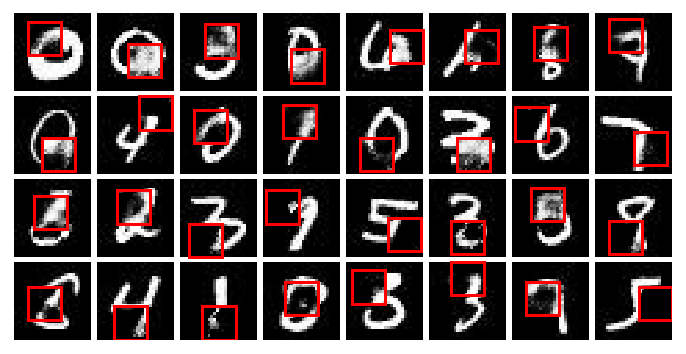

Epoch: 179


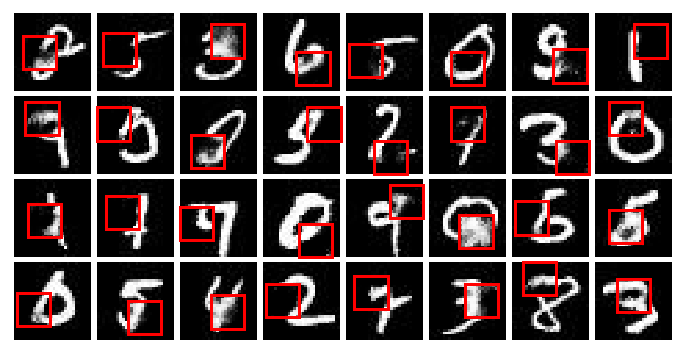

Epoch: 189


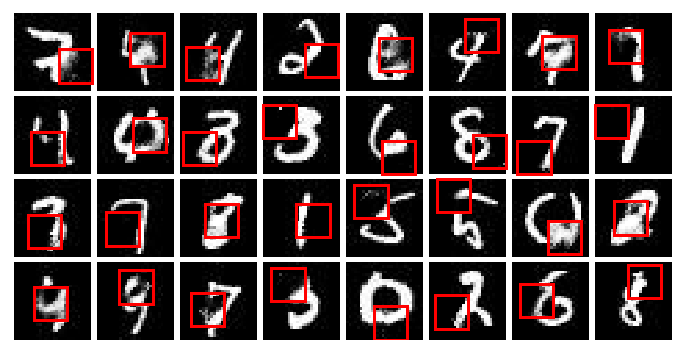

Epoch: 199


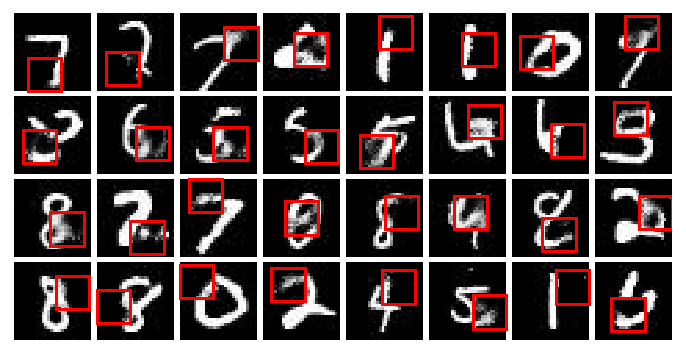

Epoch: 209


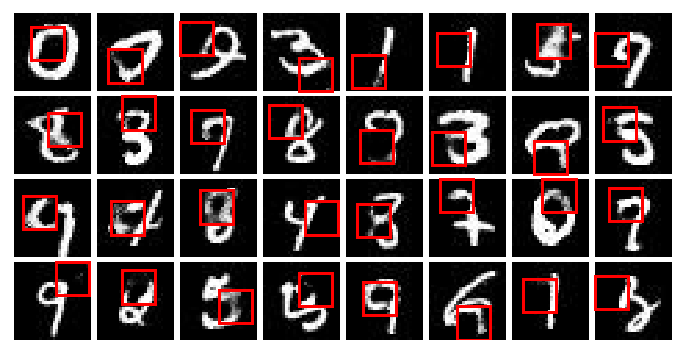

Epoch: 219


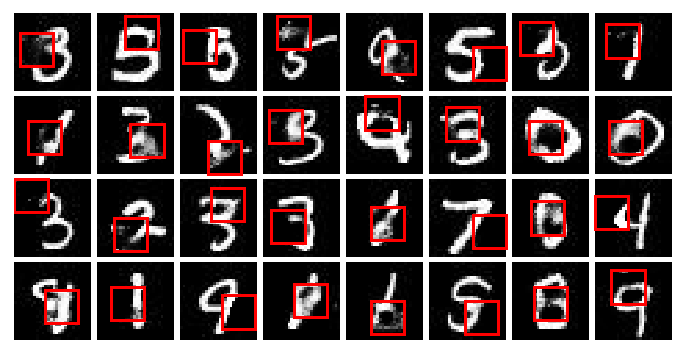

Epoch: 229


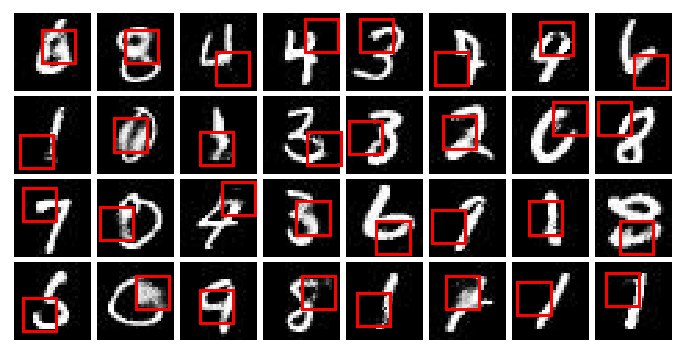

Epoch: 239


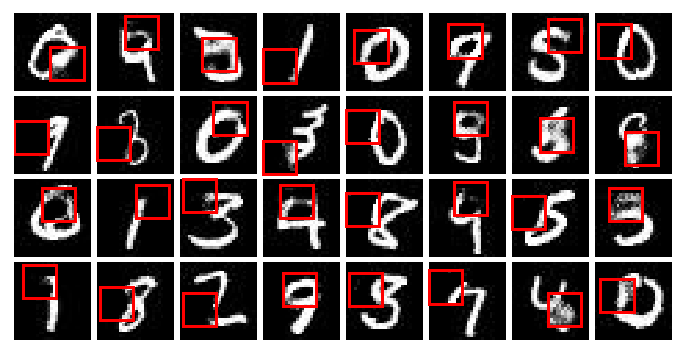

Epoch: 249


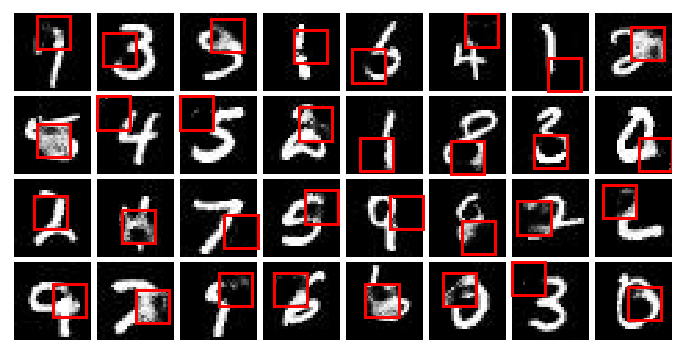

Epoch: 259


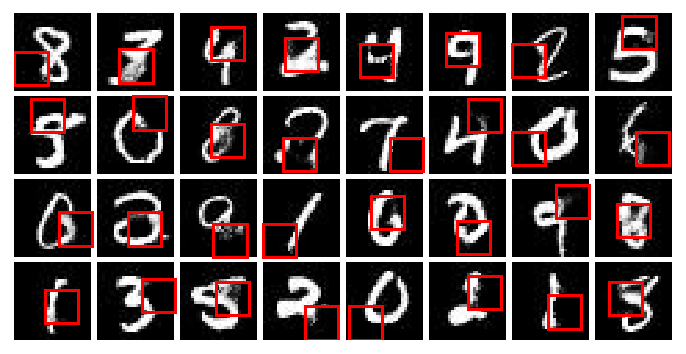

Epoch: 269


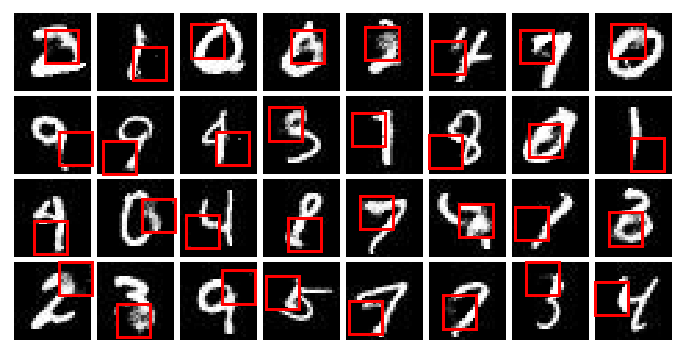

Epoch: 279


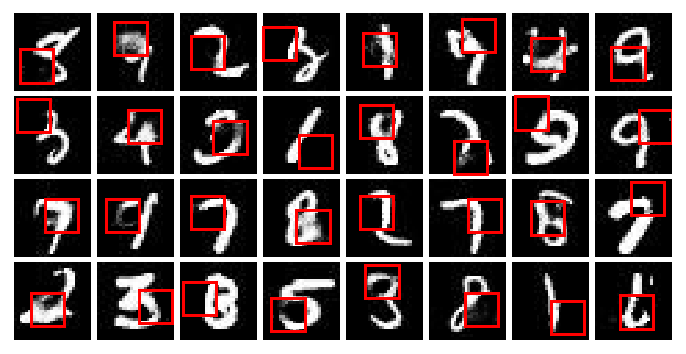

Epoch: 289


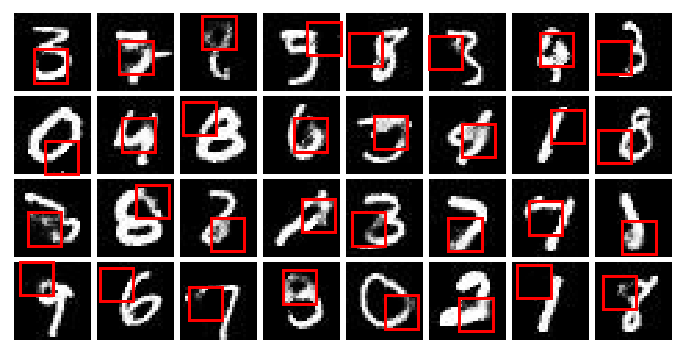

Epoch: 299


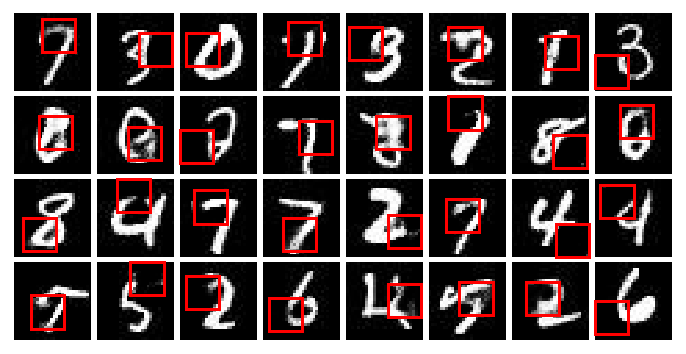

Epoch: 309


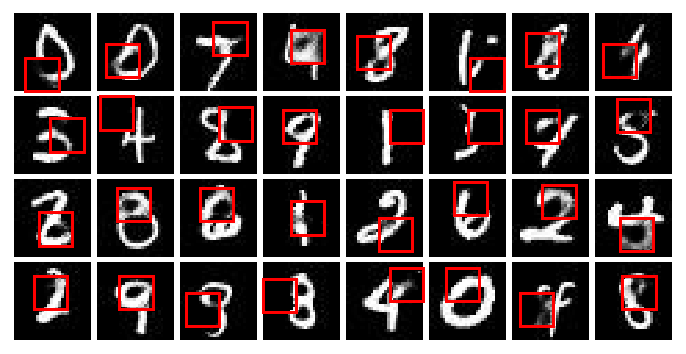

Epoch: 319


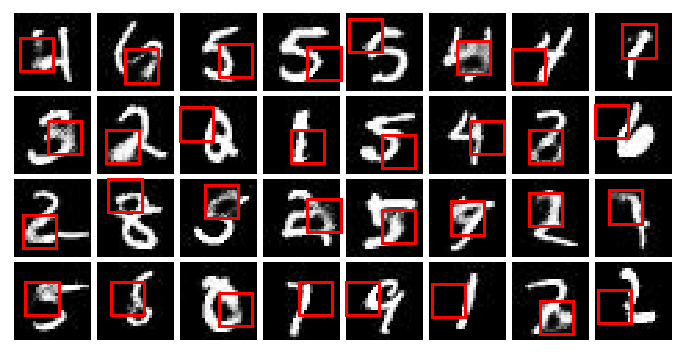

Epoch: 329


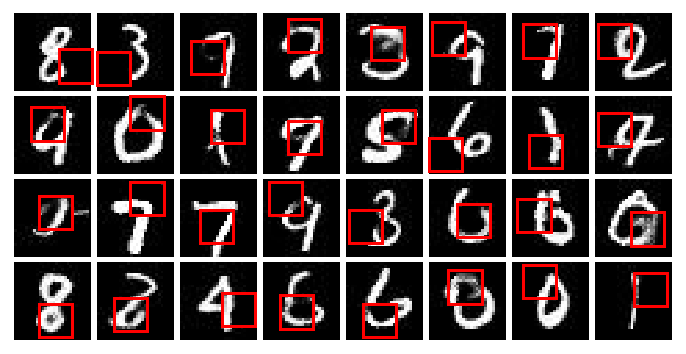

Epoch: 339


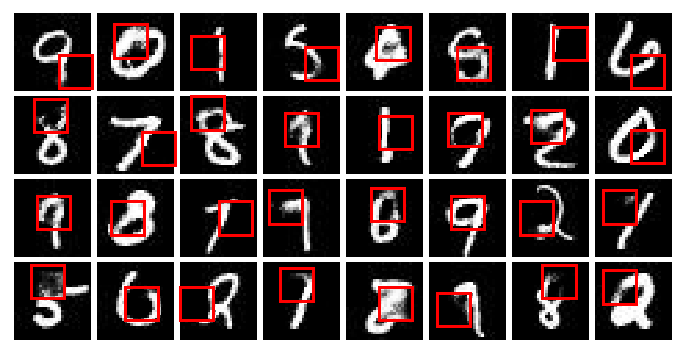

Epoch: 349


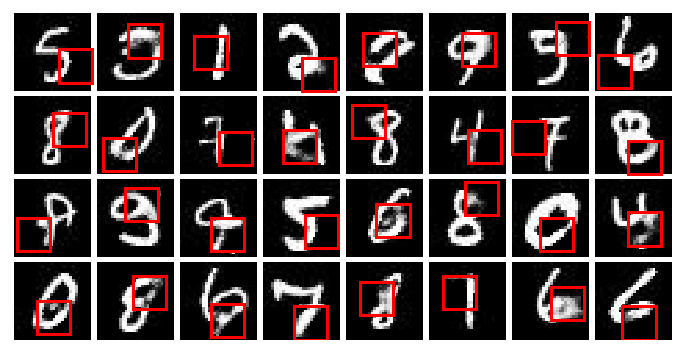

Epoch: 359


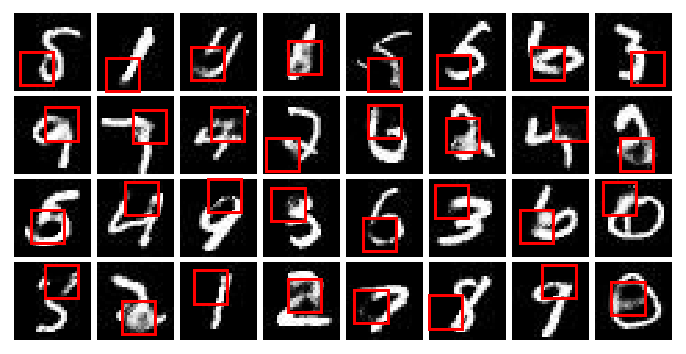

Epoch: 369


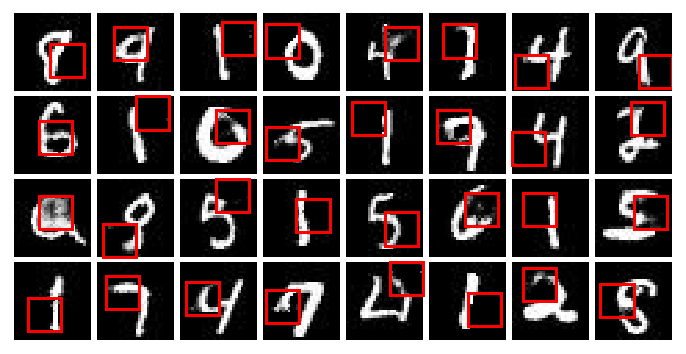

Epoch: 379


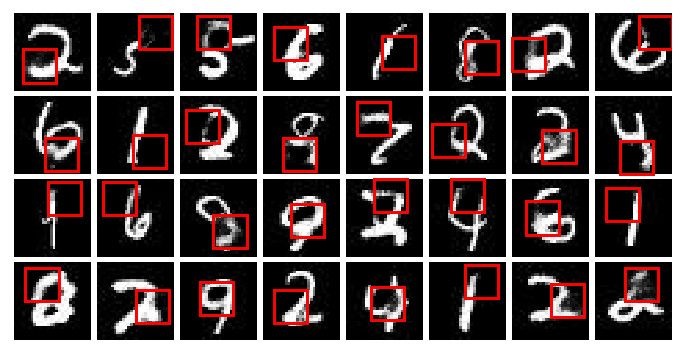

Epoch: 389


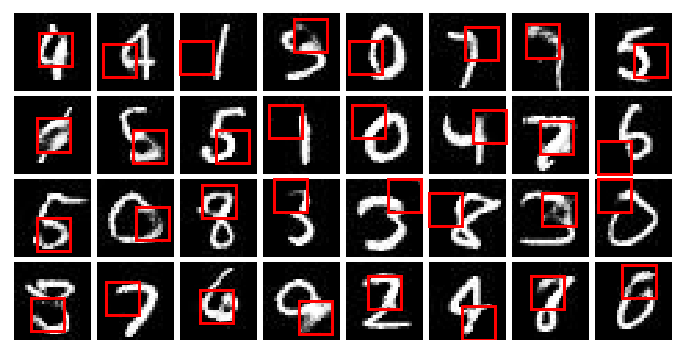

Epoch: 399


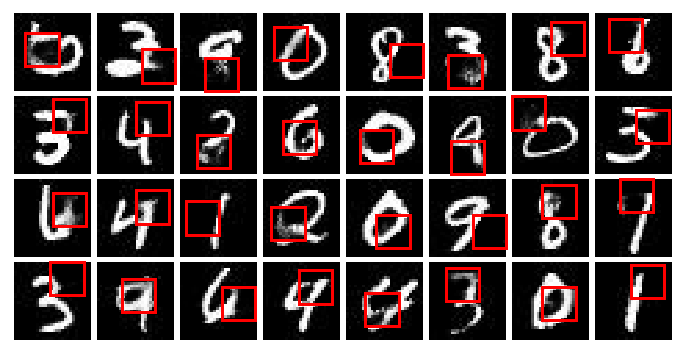

Epoch: 409


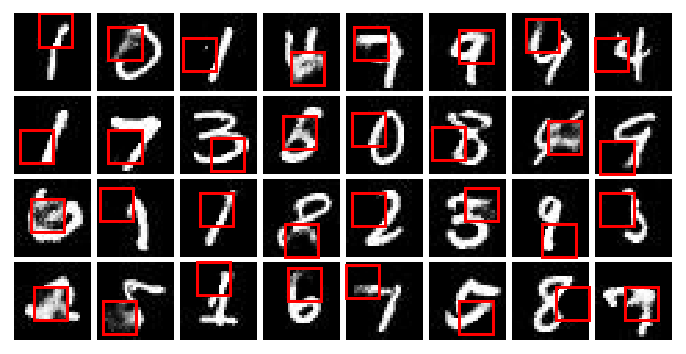

Epoch: 419


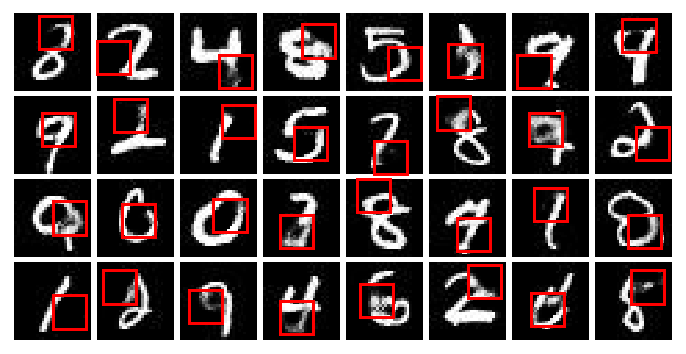

Epoch: 429


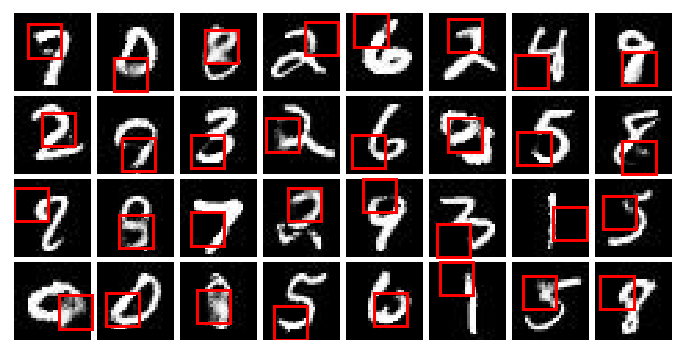

Epoch: 439


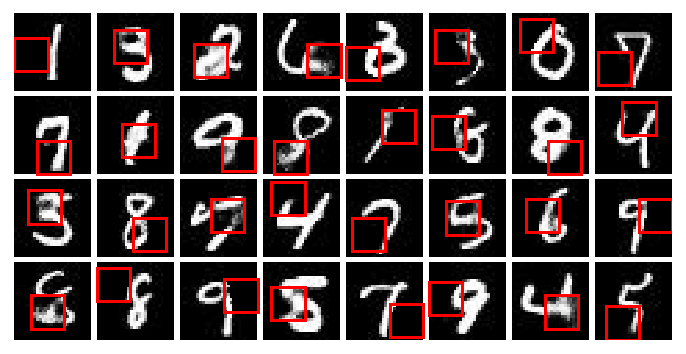

Epoch: 449


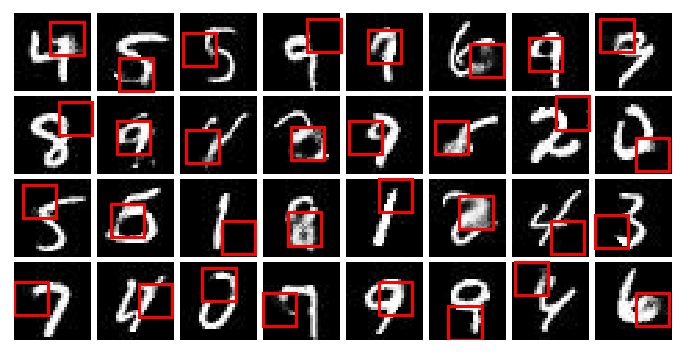

Epoch: 459


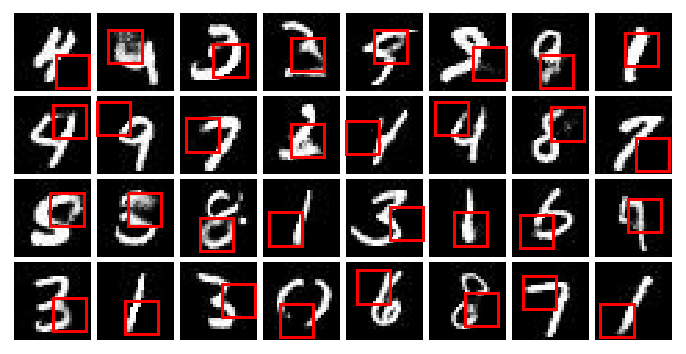

Epoch: 469


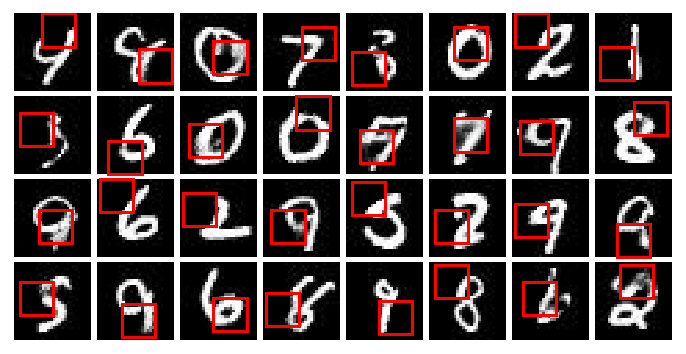

Epoch: 479


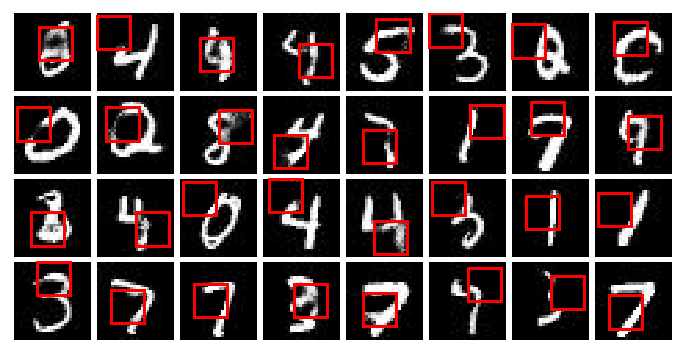

Epoch: 489


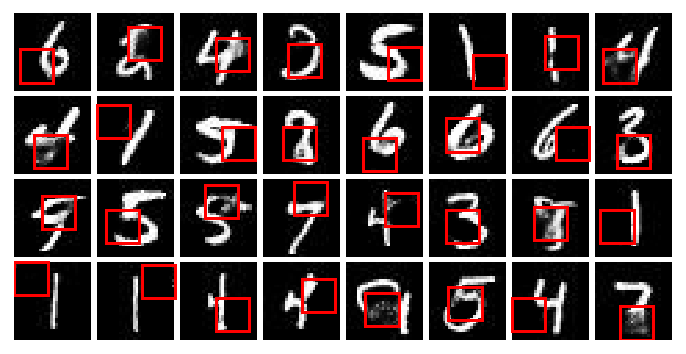

Epoch: 499


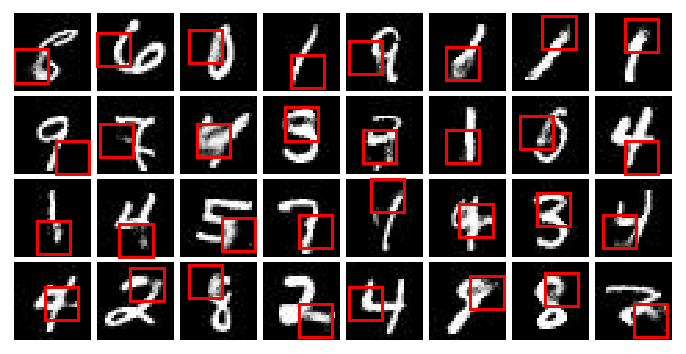

Epoch: 509


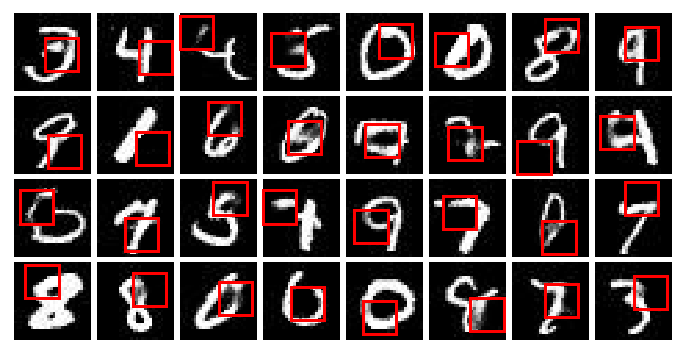

Epoch: 519


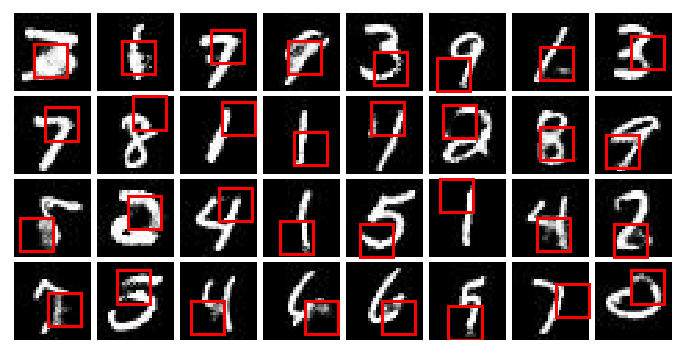

Epoch: 529


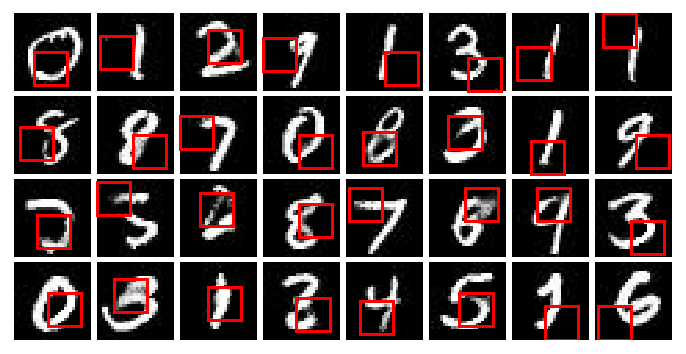

Epoch: 539


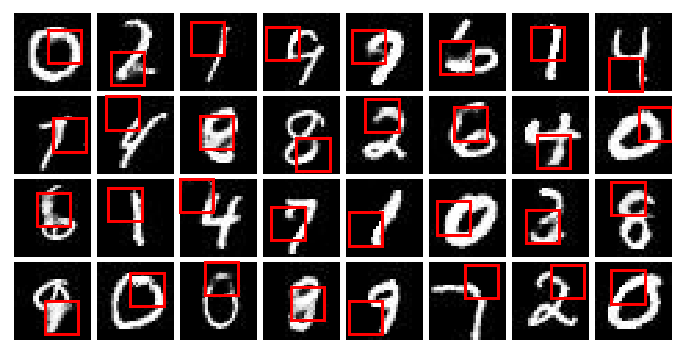

Epoch: 549


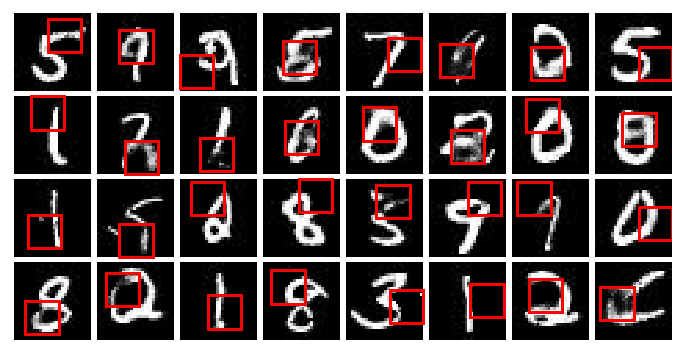

Epoch: 559


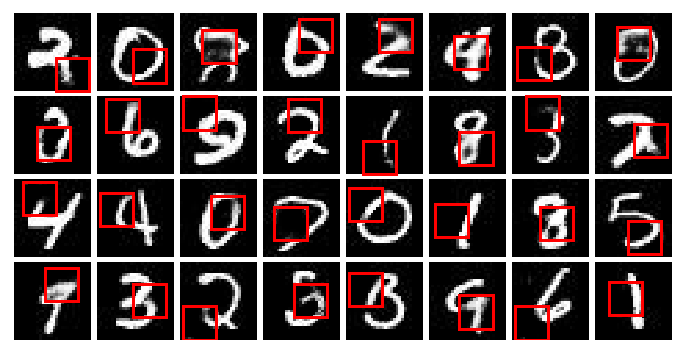

Epoch: 569


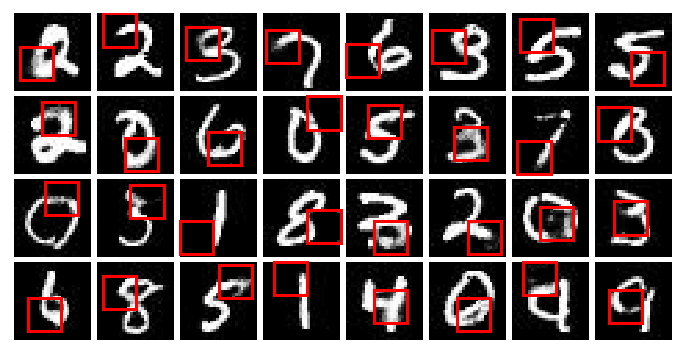

Epoch: 579


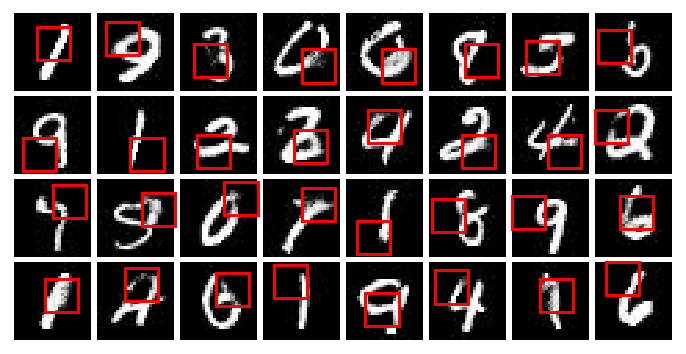

Epoch: 589


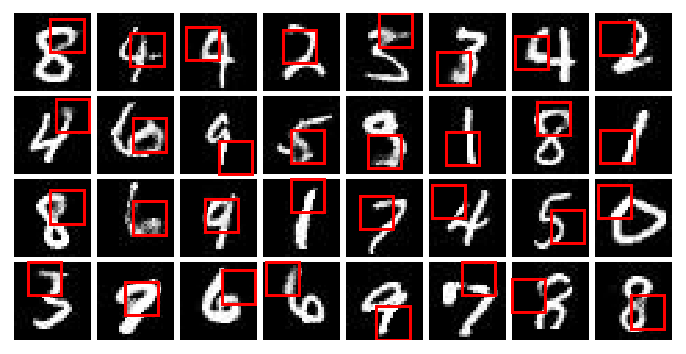

Epoch: 599


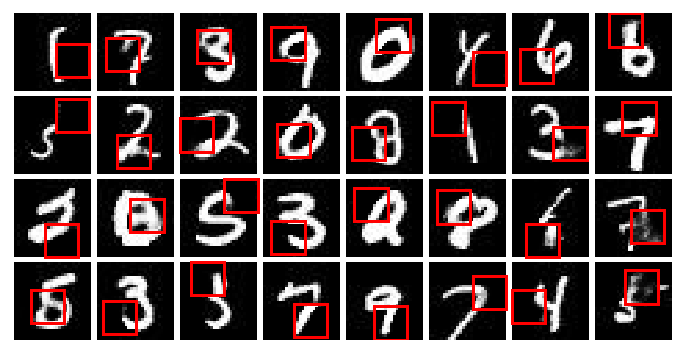

In [62]:
beta = .1
plot_interval = 10
critic_updates = 0

for epoch in range(600):
    for real_data, real_mask, index in data_loader:

        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()

        masked_real_data = mask_data(real_data, real_mask)

        # Update discriminators' parameters
        data_noise.normal_()
        fake_data = data_gen(data_noise)

        mask_noise.normal_()
        fake_mask = mask_gen(mask_noise)
        masked_fake_data = mask_data(fake_data, fake_mask)

        impu_noise.uniform_()
        imputed_data = imputer(real_data, real_mask, impu_noise)

        update_data_critic(masked_real_data, masked_fake_data)
        update_mask_critic(real_mask, fake_mask)
        update_impu_critic(fake_data, imputed_data)

        critic_updates += 1

        if critic_updates == n_critic:
            critic_updates = 0

            # Update generators' parameters
            for p in data_critic.parameters():
                p.requires_grad_(False)
            for p in mask_critic.parameters():
                p.requires_grad_(False)
            for p in impu_critic.parameters():
                p.requires_grad_(False)

            data_noise.normal_()
            fake_data = data_gen(data_noise)

            mask_noise.normal_()
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data, fake_mask)

            impu_noise.uniform_()
            imputed_data = imputer(real_data, real_mask, impu_noise)

            data_loss = -data_critic(masked_fake_data).mean()
            mask_loss = -mask_critic(fake_mask).mean()
            impu_loss = -impu_critic(imputed_data).mean()

            mask_gen.zero_grad()
            (mask_loss + data_loss * alpha).backward(retain_graph=True)
            mask_gen_optimizer.step()

            data_gen.zero_grad()
            (data_loss + impu_loss * beta).backward(retain_graph=True)
            data_gen_optimizer.step()

            imputer.zero_grad()
            impu_loss.backward()
            imputer_optimizer.step()

            for p in data_critic.parameters():
                p.requires_grad_(True)
            for p in mask_critic.parameters():
                p.requires_grad_(True)
            for p in impu_critic.parameters():
                p.requires_grad_(True)

    if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
        with torch.no_grad():
            imputer.eval()

            # Plot imputation results
            impu_noise.uniform_()
            imputed_data = imputer(real_data, real_mask, impu_noise)
            bbox = [data.mask_loc[idx] for idx in index]
            print('Epoch:', epoch)
            fig, ax = plt.subplots(figsize=(6, 3))
            plot_grid(ax, imputed_data, bbox, gap=2)
            plt.show()
            plt.close(fig)

            imputer.train()

In [63]:
impu_noise = torch.empty(1, img_size, img_size, device=device)
for i, (image, mask) in enumerate(zip(data.image, data.mask)):
    impu_noise.uniform_()
    result = imputer(image.to(device), mask.to(device).float(), impu_noise).squeeze(0).detach().cpu().numpy()
    pil_image = Image.fromarray(result*255)
    pil_image.convert('L').save('{}/imgMISGANtrain/{}.jpg'.format(ds_label, i))
for i, (image, mask) in enumerate(zip(test_data.image, test_data.mask)):
    impu_noise.uniform_()
    result = imputer(image.to(device), mask.to(device).float(), impu_noise).squeeze(0).detach().cpu().numpy()
    pil_image = Image.fromarray(result*255)
    pil_image.convert('L').save('{}/imgMISGANtest/{}.jpg'.format(ds_label, i + 8000))